In [2]:
import numpy as np
from numpy import clip
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import os
from diffusers import DDPMScheduler, DDPMPipeline
import pickle 
from torchmetrics.image.fid import FrechetInceptionDistance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from diffusers import AutoencoderKL

class VAE:
    vae_url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"

    def __init__(self, device):
        self.model = AutoencoderKL.from_single_file(self.vae_url).to(device)
        self.device = device

    def pil_to_latent(self, input):
        with torch.no_grad():
            latent = self.model.encode(input.to(self.device))
        return latent.latent_dist.sample()

    def latent_to_pil(self, encoded):
        with torch.no_grad():
            output_img = self.model.decode(encoded)
        return output_img.sample


vae = VAE(device)

In [5]:
# resize_size = 256

# transform = transforms.Compose([
#     transforms.Resize((resize_size, resize_size)),
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: vae.pil_to_latent(x.unsqueeze(0)).squeeze(0))
# ])

# data_path = 'data/data0/lsun/bedroom'
# batch_size = 32

# image_dataset = ImageFolder(root=data_path, transform=transform)
# image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:10000])
# train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

# for idx, batch in enumerate(train_dataloader):
#     break

In [6]:
# output_dir = "vae_out/bedrooms"

# for batch_idx, (inputs, _) in enumerate(tqdm(train_dataloader, "Prcessing")):
#     for img_idx, img in enumerate(inputs):
#         img = img.cpu()
#         img_filename = f'batch_{batch_idx}_img_{img_idx}.pt'
#         img_path = os.path.join(output_dir, img_filename)
#         torch.save(img, img_path)

In [7]:
from torch.utils.data import Dataset

class TensorDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.tensor_files = [f for f in os.listdir(directory) if f.endswith('.pt')]
        self.tensor_files.sort()  # Ensure consistent order

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, idx):
        tensor_path = os.path.join(self.directory, self.tensor_files[idx])
        tensor = torch.load(tensor_path)
        return tensor

output_dir = 'vae_out/bedrooms'
tensor_dataset = TensorDataset(output_dir)

batch_size = 32
train_dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

for batch in train_dataloader:
    print(batch.shape)
    break

torch.Size([32, 4, 32, 32])


In [8]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=4,  # the number of input channels, 3 for RGB images
    out_channels=4,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [9]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

In [31]:
for epoch in range(1000):
    for batch in tqdm(train_dataloader, f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        batch = batch.to(device)

        noise = torch.randn(batch.shape).to(device)
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (batch.shape[0],), device=batch.device
        ).long()

        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        
        loss.backward(loss)
        optimizer.step()

        losses.append(loss.item())
        

    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch 1: 100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


Epoch:1, loss: 0.5694332138037148


Epoch 2: 100%|██████████| 313/313 [02:55<00:00,  1.78it/s]


Epoch:2, loss: 0.5700856203469225


Epoch 3: 100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


Epoch:3, loss: 0.5724490691488162


Epoch 4: 100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


Epoch:4, loss: 0.569481609061884


Epoch 5: 100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


Epoch:5, loss: 0.5672636933791371


Epoch 6: 100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


Epoch:6, loss: 0.5630912318016393


Epoch 7: 100%|██████████| 313/313 [01:46<00:00,  2.94it/s]


Epoch:7, loss: 0.5674716978789137


Epoch 8: 100%|██████████| 313/313 [01:47<00:00,  2.91it/s]


Epoch:8, loss: 0.5667935507937362


Epoch 9: 100%|██████████| 313/313 [01:46<00:00,  2.93it/s]


Epoch:9, loss: 0.5677502798957946


Epoch 10: 100%|██████████| 313/313 [01:46<00:00,  2.93it/s]


Epoch:10, loss: 0.5740541962388986


Epoch 11: 100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch:11, loss: 0.5632761902512072


Epoch 12: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch:12, loss: 0.5745061781650154


Epoch 13: 100%|██████████| 313/313 [02:15<00:00,  2.32it/s]


Epoch:13, loss: 0.5719068091327009


Epoch 14: 100%|██████████| 313/313 [02:53<00:00,  1.81it/s]


Epoch:14, loss: 0.5658431964370009


Epoch 15: 100%|██████████| 313/313 [03:10<00:00,  1.65it/s]


Epoch:15, loss: 0.5676439916744781


Epoch 16: 100%|██████████| 313/313 [03:26<00:00,  1.51it/s]


Epoch:16, loss: 0.5685957789230651


Epoch 17: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Epoch:17, loss: 0.5635448581875323


Epoch 18: 100%|██████████| 313/313 [01:52<00:00,  2.78it/s]


Epoch:18, loss: 0.567006408692168


Epoch 19: 100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


Epoch:19, loss: 0.5673289647498451


Epoch 20: 100%|██████████| 313/313 [02:08<00:00,  2.43it/s]


Epoch:20, loss: 0.5692076316466347


Epoch 21: 100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


Epoch:21, loss: 0.5729947255823178


Epoch 22: 100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


Epoch:22, loss: 0.5676411719748768


Epoch 23: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]


Epoch:23, loss: 0.5724625870252189


Epoch 24: 100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch:24, loss: 0.5664322132500597


Epoch 25: 100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Epoch:25, loss: 0.567272258261903


Epoch 26: 100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Epoch:26, loss: 0.5719224649686783


Epoch 27: 100%|██████████| 313/313 [01:57<00:00,  2.65it/s]


Epoch:27, loss: 0.5638179761914018


Epoch 28: 100%|██████████| 313/313 [01:46<00:00,  2.94it/s]


Epoch:28, loss: 0.5624603252060497


Epoch 29: 100%|██████████| 313/313 [01:43<00:00,  3.01it/s]


Epoch:29, loss: 0.5629421380190803


Epoch 30: 100%|██████████| 313/313 [01:44<00:00,  3.01it/s]


Epoch:30, loss: 0.5689802365942885


Epoch 31: 100%|██████████| 313/313 [01:45<00:00,  2.98it/s]


Epoch:31, loss: 0.5673435813131423


Epoch 32: 100%|██████████| 313/313 [01:44<00:00,  3.00it/s]


Epoch:32, loss: 0.5671472111449074


Epoch 33: 100%|██████████| 313/313 [01:44<00:00,  2.99it/s]


Epoch:33, loss: 0.5592811383759252


Epoch 34: 100%|██████████| 313/313 [01:43<00:00,  3.01it/s]


Epoch:34, loss: 0.5618984246977602


Epoch 35: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Epoch:35, loss: 0.566494316243516


Epoch 36: 100%|██████████| 313/313 [01:45<00:00,  2.98it/s]


Epoch:36, loss: 0.5646667603296213


Epoch 37: 100%|██████████| 313/313 [01:45<00:00,  2.97it/s]


Epoch:37, loss: 0.5680135549447788


Epoch 38: 100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Epoch:38, loss: 0.5624773306206773


Epoch 39: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


Epoch:39, loss: 0.5626599096452085


Epoch 40: 100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


Epoch:40, loss: 0.569337008193659


Epoch 41: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch:41, loss: 0.5671609041218559


Epoch 42: 100%|██████████| 313/313 [03:05<00:00,  1.69it/s]


Epoch:42, loss: 0.5655477034588592


Epoch 43: 100%|██████████| 313/313 [03:41<00:00,  1.41it/s]


Epoch:43, loss: 0.5631106177838846


Epoch 44: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch:44, loss: 0.5676594024268202


Epoch 45: 100%|██████████| 313/313 [03:08<00:00,  1.66it/s]


Epoch:45, loss: 0.569906006320216


Epoch 46: 100%|██████████| 313/313 [03:25<00:00,  1.52it/s]


Epoch:46, loss: 0.56300277022508


Epoch 47: 100%|██████████| 313/313 [03:47<00:00,  1.38it/s]


Epoch:47, loss: 0.5655449250826059


Epoch 48: 100%|██████████| 313/313 [03:05<00:00,  1.69it/s]


Epoch:48, loss: 0.5635963708828813


Epoch 49: 100%|██████████| 313/313 [01:41<00:00,  3.08it/s]


Epoch:49, loss: 0.5626305269357115


Epoch 50: 100%|██████████| 313/313 [02:53<00:00,  1.80it/s]


Epoch:50, loss: 0.5609646695680892


Epoch 51: 100%|██████████| 313/313 [02:15<00:00,  2.31it/s]


Epoch:51, loss: 0.5628977866408924


Epoch 52: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch:52, loss: 0.5614192104948976


Epoch 53: 100%|██████████| 313/313 [01:17<00:00,  4.05it/s]


Epoch:53, loss: 0.5610318103918253


Epoch 54: 100%|██████████| 313/313 [01:24<00:00,  3.71it/s]


Epoch:54, loss: 0.5627364066843027


Epoch 55: 100%|██████████| 313/313 [01:23<00:00,  3.73it/s]


Epoch:55, loss: 0.5574496737874735


Epoch 56: 100%|██████████| 313/313 [01:25<00:00,  3.66it/s]


Epoch:56, loss: 0.5636061461398396


Epoch 57: 100%|██████████| 313/313 [01:26<00:00,  3.61it/s]


Epoch:57, loss: 0.5628577882108597


Epoch 58: 100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch:58, loss: 0.567415320263884


Epoch 59: 100%|██████████| 313/313 [01:21<00:00,  3.84it/s]


Epoch:59, loss: 0.5617239042973747


Epoch 60: 100%|██████████| 313/313 [01:20<00:00,  3.89it/s]


Epoch:60, loss: 0.5614067523624189


Epoch 61: 100%|██████████| 313/313 [01:20<00:00,  3.87it/s]


Epoch:61, loss: 0.5645446120359646


Epoch 62: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch:62, loss: 0.5643189835091369


Epoch 63: 100%|██████████| 313/313 [01:24<00:00,  3.72it/s]


Epoch:63, loss: 0.5609234795212364


Epoch 64: 100%|██████████| 313/313 [01:24<00:00,  3.70it/s]


Epoch:64, loss: 0.5691221988620088


Epoch 65: 100%|██████████| 313/313 [01:26<00:00,  3.62it/s]


Epoch:65, loss: 0.5626545057129174


Epoch 66: 100%|██████████| 313/313 [01:20<00:00,  3.91it/s]


Epoch:66, loss: 0.5660429180811007


Epoch 67: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:67, loss: 0.5648165141431668


Epoch 68: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch:68, loss: 0.5655778260848012


Epoch 69: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:69, loss: 0.5604743603319405


Epoch 70: 100%|██████████| 313/313 [01:12<00:00,  4.35it/s]


Epoch:70, loss: 0.5641304313565214


Epoch 71: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:71, loss: 0.5547338400405055


Epoch 72: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:72, loss: 0.5600356542454741


Epoch 73: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:73, loss: 0.5628927017743595


Epoch 74: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:74, loss: 0.5563438274799445


Epoch 75: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:75, loss: 0.5607882205861064


Epoch 76: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:76, loss: 0.5637377996604663


Epoch 77: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:77, loss: 0.5627294127552654


Epoch 78: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:78, loss: 0.5568167024527114


Epoch 79: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:79, loss: 0.5631275370288581


Epoch 80: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:80, loss: 0.5590024172498015


Epoch 81: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:81, loss: 0.5623944461726533


Epoch 82: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:82, loss: 0.5626541225674053


Epoch 83: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:83, loss: 0.5607207439387568


Epoch 84: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:84, loss: 0.5622463868068049


Epoch 85: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:85, loss: 0.5536329854791537


Epoch 86: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch:86, loss: 0.5626547977375908


Epoch 87: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:87, loss: 0.558831237661191


Epoch 88: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:88, loss: 0.5635036002523222


Epoch 89: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:89, loss: 0.5608249988418799


Epoch 90: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:90, loss: 0.5595520649093408


Epoch 91: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:91, loss: 0.5574505359600908


Epoch 92: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:92, loss: 0.5603009970805135


Epoch 93: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:93, loss: 0.5561588558906945


Epoch 94: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:94, loss: 0.5635181740640451


Epoch 95: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:95, loss: 0.5588356081289224


Epoch 96: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:96, loss: 0.5608556240130538


Epoch 97: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:97, loss: 0.5574867258818386


Epoch 98: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:98, loss: 0.5579570913657593


Epoch 99: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:99, loss: 0.5614826327886063


Epoch 100: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:100, loss: 0.5590004954284753


Epoch 101: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:101, loss: 0.5652150179440982


Epoch 102: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:102, loss: 0.5553272858785745


Epoch 103: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:103, loss: 0.5542748501887337


Epoch 104: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:104, loss: 0.5599825913532854


Epoch 105: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch:105, loss: 0.5562910850817403


Epoch 106: 100%|██████████| 313/313 [01:13<00:00,  4.26it/s]


Epoch:106, loss: 0.5537418630747749


Epoch 107: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch:107, loss: 0.5621669448602694


Epoch 108: 100%|██████████| 313/313 [01:26<00:00,  3.63it/s]


Epoch:108, loss: 0.556511286729441


Epoch 109: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch:109, loss: 0.5507014971762039


Epoch 110: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:110, loss: 0.5522686668668693


Epoch 111: 100%|██████████| 313/313 [01:13<00:00,  4.26it/s]


Epoch:111, loss: 0.5565608848398105


Epoch 112: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch:112, loss: 0.5554290133924149


Epoch 113: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:113, loss: 0.5613239187592516


Epoch 114: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:114, loss: 0.5547352533180493


Epoch 115: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:115, loss: 0.5558685576572967


Epoch 116: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:116, loss: 0.5602890497769791


Epoch 117: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:117, loss: 0.557513879225277


Epoch 118: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:118, loss: 0.5562993148073982


Epoch 119: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:119, loss: 0.5549723585002339


Epoch 120: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:120, loss: 0.5559866505499464


Epoch 121: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:121, loss: 0.5590504232686929


Epoch 122: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:122, loss: 0.5541828495625871


Epoch 123: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:123, loss: 0.5554828833276853


Epoch 124: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:124, loss: 0.5522737750610985


Epoch 125: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:125, loss: 0.554569415581493


Epoch 126: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:126, loss: 0.5588589929544125


Epoch 127: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:127, loss: 0.5599047012222461


Epoch 128: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:128, loss: 0.5597267363208551


Epoch 129: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:129, loss: 0.5572752109922159


Epoch 130: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:130, loss: 0.5558845783574894


Epoch 131: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:131, loss: 0.549167771594593


Epoch 132: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:132, loss: 0.5608134468713888


Epoch 133: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:133, loss: 0.5574434073017047


Epoch 134: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:134, loss: 0.5587929684323625


Epoch 135: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:135, loss: 0.5614807959943534


Epoch 136: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:136, loss: 0.5566991310530958


Epoch 137: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:137, loss: 0.5544489060347073


Epoch 138: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:138, loss: 0.5565994220991104


Epoch 139: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:139, loss: 0.5561627353342197


Epoch 140: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:140, loss: 0.5557067291424297


Epoch 141: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:141, loss: 0.5554482131339491


Epoch 142: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch:142, loss: 0.5562173956499313


Epoch 143: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:143, loss: 0.5602832939297246


Epoch 144: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:144, loss: 0.5526391302053921


Epoch 145: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:145, loss: 0.5585569890733725


Epoch 146: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:146, loss: 0.5537161663317451


Epoch 147: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:147, loss: 0.5573179633282244


Epoch 148: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:148, loss: 0.5545008824275325


Epoch 149: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:149, loss: 0.5504993803013628


Epoch 150: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:150, loss: 0.5546825272968402


Epoch 151: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:151, loss: 0.5505667078418853


Epoch 152: 100%|██████████| 313/313 [01:12<00:00,  4.35it/s]


Epoch:152, loss: 0.5559455095388638


Epoch 153: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:153, loss: 0.5589671973793652


Epoch 154: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:154, loss: 0.5577697870068656


Epoch 155: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:155, loss: 0.5554823517418517


Epoch 156: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch:156, loss: 0.5546843303849522


Epoch 157: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Epoch:157, loss: 0.5550149046955779


Epoch 158: 100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch:158, loss: 0.5596374445639479


Epoch 159: 100%|██████████| 313/313 [01:22<00:00,  3.79it/s]


Epoch:159, loss: 0.5526237831519435


Epoch 160: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s]


Epoch:160, loss: 0.5579884014190576


Epoch 161: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:161, loss: 0.5575117488829092


Epoch 162: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:162, loss: 0.5603809394775489


Epoch 163: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:163, loss: 0.5584927852542255


Epoch 164: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:164, loss: 0.5540454035368971


Epoch 165: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:165, loss: 0.5521377091781019


Epoch 166: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:166, loss: 0.5564566313649137


Epoch 167: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:167, loss: 0.5556643468122513


Epoch 168: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:168, loss: 0.5566171222982316


Epoch 169: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:169, loss: 0.5608455178836664


Epoch 170: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:170, loss: 0.5532529140813663


Epoch 171: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:171, loss: 0.5554766639733848


Epoch 172: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:172, loss: 0.5551472727102212


Epoch 173: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:173, loss: 0.5580909174090376


Epoch 174: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:174, loss: 0.5573293975176522


Epoch 175: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:175, loss: 0.5580408864508802


Epoch 176: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:176, loss: 0.5556140651527685


Epoch 177: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:177, loss: 0.5578662492215823


Epoch 178: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:178, loss: 0.551947733179068


Epoch 179: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:179, loss: 0.5521021139697907


Epoch 180: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:180, loss: 0.5559725415782807


Epoch 181: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:181, loss: 0.5576236346087897


Epoch 182: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:182, loss: 0.5568280920814782


Epoch 183: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:183, loss: 0.5506360652728584


Epoch 184: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:184, loss: 0.5552953297909076


Epoch 185: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch:185, loss: 0.5570012270071255


Epoch 186: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:186, loss: 0.5567628160452309


Epoch 187: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:187, loss: 0.5512261319274719


Epoch 188: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:188, loss: 0.5549535620898104


Epoch 189: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:189, loss: 0.5594575114714833


Epoch 190: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:190, loss: 0.5530311848028019


Epoch 191: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:191, loss: 0.549197144401721


Epoch 192: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:192, loss: 0.5556942858635047


Epoch 193: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:193, loss: 0.5547203611070737


Epoch 194: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:194, loss: 0.5549535740869114


Epoch 195: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:195, loss: 0.5497350077659559


Epoch 196: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:196, loss: 0.5514531155554251


Epoch 197: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:197, loss: 0.5526829854177591


Epoch 198: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:198, loss: 0.5533478459991967


Epoch 199: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:199, loss: 0.5541656339130463


Epoch 200: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:200, loss: 0.5539471021475503


Epoch 201: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:201, loss: 0.5511409587943896


Epoch 202: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:202, loss: 0.5526192813826064


Epoch 203: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:203, loss: 0.5523177030177924


Epoch 204: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:204, loss: 0.5489555852481732


Epoch 205: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:205, loss: 0.5550751759411808


Epoch 206: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:206, loss: 0.5573928810346621


Epoch 207: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:207, loss: 0.5543498826293519


Epoch 208: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:208, loss: 0.5555904630464487


Epoch 209: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:209, loss: 0.5559259142738562


Epoch 210: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch:210, loss: 0.5530158089943968


Epoch 211: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:211, loss: 0.5578228534220125


Epoch 212: 100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch:212, loss: 0.5601029684558844


Epoch 213: 100%|██████████| 313/313 [01:19<00:00,  3.95it/s]


Epoch:213, loss: 0.5544217520247633


Epoch 214: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s]


Epoch:214, loss: 0.5535108353764104


Epoch 215: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:215, loss: 0.5556673920763948


Epoch 216: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:216, loss: 0.5546874431565928


Epoch 217: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:217, loss: 0.555957212996559


Epoch 218: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:218, loss: 0.5504971262745963


Epoch 219: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:219, loss: 0.5562198032586338


Epoch 220: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:220, loss: 0.5470601014626293


Epoch 221: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:221, loss: 0.5516752613999973


Epoch 222: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:222, loss: 0.5512707744733975


Epoch 223: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:223, loss: 0.5545129198045395


Epoch 224: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:224, loss: 0.5537819158726226


Epoch 225: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:225, loss: 0.5555783675882382


Epoch 226: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:226, loss: 0.5434351781496225


Epoch 227: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:227, loss: 0.5556999437344341


Epoch 228: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:228, loss: 0.5508193037570855


Epoch 229: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:229, loss: 0.5550854024224388


Epoch 230: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:230, loss: 0.5600296371280195


Epoch 231: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:231, loss: 0.5471898112624598


Epoch 232: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:232, loss: 0.552314961489778


Epoch 233: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:233, loss: 0.5541799822554421


Epoch 234: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:234, loss: 0.5561768973406892


Epoch 235: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:235, loss: 0.5502551713119299


Epoch 236: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:236, loss: 0.5527455894330058


Epoch 237: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:237, loss: 0.550398376041327


Epoch 238: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:238, loss: 0.5519042195984349


Epoch 239: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:239, loss: 0.5506446709076818


Epoch 240: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:240, loss: 0.5496838153741611


Epoch 241: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:241, loss: 0.5488943210996378


Epoch 242: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:242, loss: 0.5528808414174345


Epoch 243: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:243, loss: 0.5527368801089522


Epoch 244: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:244, loss: 0.5515803172946357


Epoch 245: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:245, loss: 0.5519216531953111


Epoch 246: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:246, loss: 0.5559046525543871


Epoch 247: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:247, loss: 0.5469546157140701


Epoch 248: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:248, loss: 0.5549478452807417


Epoch 249: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:249, loss: 0.548167788563445


Epoch 250: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:250, loss: 0.5482416370996652


Epoch 251: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:251, loss: 0.5486691580793728


Epoch 252: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:252, loss: 0.5486968671932769


Epoch 253: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:253, loss: 0.5525131621680701


Epoch 254: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:254, loss: 0.550552740835915


Epoch 255: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:255, loss: 0.5538454559473945


Epoch 256: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:256, loss: 0.5518106688706639


Epoch 257: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:257, loss: 0.5497191036090302


Epoch 258: 100%|██████████| 313/313 [01:22<00:00,  3.78it/s]


Epoch:258, loss: 0.5544444387332319


Epoch 259: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:259, loss: 0.5517257117806151


Epoch 260: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:260, loss: 0.5543410627605816


Epoch 261: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:261, loss: 0.5516199818053565


Epoch 262: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:262, loss: 0.5478035053506065


Epoch 263: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:263, loss: 0.5471584841656608


Epoch 264: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:264, loss: 0.5540321395991329


Epoch 265: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch:265, loss: 0.5517388065211689


Epoch 266: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:266, loss: 0.5490791801446543


Epoch 267: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:267, loss: 0.5579567284058458


Epoch 268: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:268, loss: 0.553023944361903


Epoch 269: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:269, loss: 0.5461437630767639


Epoch 270: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:270, loss: 0.5508906563250021


Epoch 271: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:271, loss: 0.5542889258351189


Epoch 272: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:272, loss: 0.5492117138335499


Epoch 273: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:273, loss: 0.5504473534445412


Epoch 274: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:274, loss: 0.5523186768777073


Epoch 275: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:275, loss: 0.5509888313639278


Epoch 276: 100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch:276, loss: 0.5533413450938826


Epoch 277: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:277, loss: 0.5524310921899046


Epoch 278: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:278, loss: 0.548878622416871


Epoch 279: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:279, loss: 0.5511381624224848


Epoch 280: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:280, loss: 0.545574204704632


Epoch 281: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:281, loss: 0.5502142408214057


Epoch 282: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:282, loss: 0.5539671962444013


Epoch 283: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:283, loss: 0.552979023787922


Epoch 284: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:284, loss: 0.5524276288363118


Epoch 285: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:285, loss: 0.5532001514023486


Epoch 286: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:286, loss: 0.5517251315398719


Epoch 287: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:287, loss: 0.5515870938476283


Epoch 288: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:288, loss: 0.5498838118090036


Epoch 289: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:289, loss: 0.5549381031586339


Epoch 290: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:290, loss: 0.554538641208277


Epoch 291: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:291, loss: 0.5478413510627259


Epoch 292: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:292, loss: 0.5527612837358785


Epoch 293: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:293, loss: 0.5513193686358845


Epoch 294: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:294, loss: 0.5460211734611767


Epoch 295: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:295, loss: 0.5461421627967883


Epoch 296: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch:296, loss: 0.5533303947875294


Epoch 297: 100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch:297, loss: 0.5528946472242617


Epoch 298: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:298, loss: 0.5479596510481911


Epoch 299: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:299, loss: 0.5504422422986441


Epoch 300: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:300, loss: 0.5510172147910816


Epoch 301: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:301, loss: 0.548758967806356


Epoch 302: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:302, loss: 0.5469617661767112


Epoch 303: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:303, loss: 0.5493219279633543


Epoch 304: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:304, loss: 0.5509403431758332


Epoch 305: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:305, loss: 0.5483807763352562


Epoch 306: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:306, loss: 0.5524936532631469


Epoch 307: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:307, loss: 0.5508498241916632


Epoch 308: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:308, loss: 0.5458768867075253


Epoch 309: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:309, loss: 0.5493644048421147


Epoch 310: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:310, loss: 0.5485606253527986


Epoch 311: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:311, loss: 0.5516749637576338


Epoch 312: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:312, loss: 0.5485173542849934


Epoch 313: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:313, loss: 0.5490063704050387


Epoch 314: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:314, loss: 0.5489829235945266


Epoch 315: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:315, loss: 0.5476412994983478


Epoch 316: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:316, loss: 0.5567509576725883


Epoch 317: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:317, loss: 0.5521778332920501


Epoch 318: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:318, loss: 0.5534407697356166


Epoch 319: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch:319, loss: 0.5497118369839824


Epoch 320: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:320, loss: 0.5425152565343693


Epoch 321: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:321, loss: 0.54889926371483


Epoch 322: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:322, loss: 0.5524309037592464


Epoch 323: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:323, loss: 0.552008713777073


Epoch 324: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:324, loss: 0.5482839493515392


Epoch 325: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:325, loss: 0.5538009420370522


Epoch 326: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:326, loss: 0.5432497162026719


Epoch 327: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:327, loss: 0.5522614032887041


Epoch 328: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:328, loss: 0.5482184106168656


Epoch 329: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:329, loss: 0.5510108124333829


Epoch 330: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:330, loss: 0.5479714474358117


Epoch 331: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:331, loss: 0.5494805683914464


Epoch 332: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:332, loss: 0.5506677960816283


Epoch 333: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:333, loss: 0.5543062347954455


Epoch 334: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:334, loss: 0.5515862342458182


Epoch 335: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:335, loss: 0.5464694324773721


Epoch 336: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:336, loss: 0.5471872211264345


Epoch 337: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:337, loss: 0.5475386246896019


Epoch 338: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:338, loss: 0.5521206945276108


Epoch 339: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:339, loss: 0.552139126169034


Epoch 340: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:340, loss: 0.5468503632865394


Epoch 341: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:341, loss: 0.5530497916399861


Epoch 342: 100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch:342, loss: 0.5488273601372021


Epoch 343: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:343, loss: 0.5464620872046619


Epoch 344: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:344, loss: 0.5474463797415408


Epoch 345: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:345, loss: 0.550114076644087


Epoch 346: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:346, loss: 0.5526031971739503


Epoch 347: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:347, loss: 0.5516554162906001


Epoch 348: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:348, loss: 0.547408299705091


Epoch 349: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:349, loss: 0.5526179984545174


Epoch 350: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:350, loss: 0.541993517273912


Epoch 351: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:351, loss: 0.5470716223930018


Epoch 352: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:352, loss: 0.5507813772073569


Epoch 353: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:353, loss: 0.5519400246607991


Epoch 354: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:354, loss: 0.5428064804488477


Epoch 355: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:355, loss: 0.5481301200466034


Epoch 356: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:356, loss: 0.5497664177950959


Epoch 357: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:357, loss: 0.5466133102822227


Epoch 358: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:358, loss: 0.5499572151194746


Epoch 359: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:359, loss: 0.5471420181445039


Epoch 360: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:360, loss: 0.5484947432725193


Epoch 361: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:361, loss: 0.5464580139032187


Epoch 362: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:362, loss: 0.546998884350347


Epoch 363: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:363, loss: 0.5446884533086904


Epoch 364: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:364, loss: 0.5479112876870762


Epoch 365: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:365, loss: 0.549464415151852


Epoch 366: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:366, loss: 0.5469115131769698


Epoch 367: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:367, loss: 0.5480767401833885


Epoch 368: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:368, loss: 0.5483395794329171


Epoch 369: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:369, loss: 0.5465235668249404


Epoch 370: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:370, loss: 0.5439406786673366


Epoch 371: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:371, loss: 0.5510997544652738


Epoch 372: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:372, loss: 0.5497605336931186


Epoch 373: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:373, loss: 0.5443033309409413


Epoch 374: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:374, loss: 0.5488869569743403


Epoch 375: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:375, loss: 0.5487262137210407


Epoch 376: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:376, loss: 0.5478254816593072


Epoch 377: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:377, loss: 0.5496292331348211


Epoch 378: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:378, loss: 0.5519705254810686


Epoch 379: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:379, loss: 0.5432738203781481


Epoch 380: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch:380, loss: 0.546114803883976


Epoch 381: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch:381, loss: 0.5468147372285398


Epoch 382: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:382, loss: 0.5450589488299129


Epoch 383: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:383, loss: 0.5477446138668365


Epoch 384: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:384, loss: 0.543425500583344


Epoch 385: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:385, loss: 0.5419340419312255


Epoch 386: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:386, loss: 0.5468827795487242


Epoch 387: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:387, loss: 0.5463572808157522


Epoch 388: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:388, loss: 0.551463486763616


Epoch 389: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:389, loss: 0.5447358833715177


Epoch 390: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:390, loss: 0.5487054245540509


Epoch 391: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:391, loss: 0.5480473518562012


Epoch 392: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:392, loss: 0.5496813294034415


Epoch 393: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:393, loss: 0.5476557812370813


Epoch 394: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:394, loss: 0.5492554960159448


Epoch 395: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:395, loss: 0.5498853430580407


Epoch 396: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:396, loss: 0.5447972862484356


Epoch 397: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:397, loss: 0.5472795998516936


Epoch 398: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:398, loss: 0.5490319427019491


Epoch 399: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:399, loss: 0.5475033415963475


Epoch 400: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:400, loss: 0.5452966782422112


Epoch 401: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:401, loss: 0.5451105109418923


Epoch 402: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:402, loss: 0.5464304672262539


Epoch 403: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:403, loss: 0.5480038203751317


Epoch 404: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:404, loss: 0.5472872203912217


Epoch 405: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:405, loss: 0.5439465152569853


Epoch 406: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:406, loss: 0.5489768207834932


Epoch 407: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:407, loss: 0.5464967935801314


Epoch 408: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:408, loss: 0.5483586122624029


Epoch 409: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:409, loss: 0.5456042599182921


Epoch 410: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:410, loss: 0.5462943628763619


Epoch 411: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:411, loss: 0.5509466393687092


Epoch 412: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:412, loss: 0.548800075396943


Epoch 413: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:413, loss: 0.5440355980167755


Epoch 414: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:414, loss: 0.5439967124606855


Epoch 415: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:415, loss: 0.5418836661992362


Epoch 416: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch:416, loss: 0.5466164325753721


Epoch 417: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:417, loss: 0.5499042673423268


Epoch 418: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:418, loss: 0.5472517929518946


Epoch 419: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:419, loss: 0.5463089082187738


Epoch 420: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:420, loss: 0.5458126361377704


Epoch 421: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:421, loss: 0.546213873659079


Epoch 422: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:422, loss: 0.5446981061190462


Epoch 423: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:423, loss: 0.5511799496583665


Epoch 424: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:424, loss: 0.5479068310496906


Epoch 425: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:425, loss: 0.5482591948570154


Epoch 426: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:426, loss: 0.5470674086493045


Epoch 427: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:427, loss: 0.5471653209898037


Epoch 428: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s]


Epoch:428, loss: 0.5491075451952961


Epoch 429: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:429, loss: 0.553293454475677


Epoch 430: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:430, loss: 0.5440876316338682


Epoch 431: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:431, loss: 0.5471054418399312


Epoch 432: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:432, loss: 0.5475297972988397


Epoch 433: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:433, loss: 0.5458245365954817


Epoch 434: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:434, loss: 0.5467791329747953


Epoch 435: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:435, loss: 0.5511334281379041


Epoch 436: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:436, loss: 0.5472009239105371


Epoch 437: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:437, loss: 0.5458235606408348


Epoch 438: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:438, loss: 0.5538916741125881


Epoch 439: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:439, loss: 0.5455111070943717


Epoch 440: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:440, loss: 0.5506587646449336


Epoch 441: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:441, loss: 0.5474166843456963


Epoch 442: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:442, loss: 0.546820012810893


Epoch 443: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch:443, loss: 0.5526050071175487


Epoch 444: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:444, loss: 0.5489281461642573


Epoch 445: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:445, loss: 0.5473808880431202


Epoch 446: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:446, loss: 0.5527784407329255


Epoch 447: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch:447, loss: 0.5431680340355578


Epoch 448: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:448, loss: 0.5438004280812443


Epoch 449: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:449, loss: 0.5455439051690574


Epoch 450: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:450, loss: 0.5456514770801837


Epoch 451: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:451, loss: 0.5519405057826362


Epoch 452: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:452, loss: 0.5450626598379482


Epoch 453: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:453, loss: 0.5459537213793197


Epoch 454: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:454, loss: 0.5480714970693802


Epoch 455: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:455, loss: 0.5421434852261894


Epoch 456: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:456, loss: 0.5452116350777233


Epoch 457: 100%|██████████| 313/313 [01:10<00:00,  4.45it/s]


Epoch:457, loss: 0.547055000885607


Epoch 458: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:458, loss: 0.5422300435483646


Epoch 459: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:459, loss: 0.544855744979633


Epoch 460: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:460, loss: 0.5454690764887264


Epoch 461: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:461, loss: 0.5455565666809631


Epoch 462: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:462, loss: 0.5393014992959202


Epoch 463: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:463, loss: 0.5416383726147417


Epoch 464: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:464, loss: 0.5456206877581989


Epoch 465: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:465, loss: 0.5437067426241244


Epoch 466: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:466, loss: 0.5491875332003584


Epoch 467: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:467, loss: 0.5407711237002486


Epoch 468: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:468, loss: 0.541079211920595


Epoch 469: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:469, loss: 0.5508912798886101


Epoch 470: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:470, loss: 0.5476530047651297


Epoch 471: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:471, loss: 0.5407431337018364


Epoch 472: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]


Epoch:472, loss: 0.5491223333361811


Epoch 473: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:473, loss: 0.5431364576656598


Epoch 474: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:474, loss: 0.5464447552974994


Epoch 475: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:475, loss: 0.5450295470773984


Epoch 476: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:476, loss: 0.5411036547761374


Epoch 477: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:477, loss: 0.5443092939762262


Epoch 478: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:478, loss: 0.5463697098124142


Epoch 479: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:479, loss: 0.5475523159526788


Epoch 480: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:480, loss: 0.5446422496161902


Epoch 481: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:481, loss: 0.5426324263167458


Epoch 482: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:482, loss: 0.5452092797421038


Epoch 483: 100%|██████████| 313/313 [01:11<00:00,  4.41it/s]


Epoch:483, loss: 0.5506975137578032


Epoch 484: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:484, loss: 0.5431888864253657


Epoch 485: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]


Epoch:485, loss: 0.5450866948872709


Epoch 486: 100%|██████████| 313/313 [01:11<00:00,  4.38it/s]


Epoch:486, loss: 0.545384372194735


Epoch 487: 100%|██████████| 313/313 [01:10<00:00,  4.42it/s]


Epoch:487, loss: 0.5451070761528259


Epoch 488: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s]


Epoch:488, loss: 0.541646818193003


Epoch 489: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:489, loss: 0.5473950584285175


Epoch 490: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:490, loss: 0.5454154580165023


Epoch 491: 100%|██████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch:491, loss: 0.54249162243578


Epoch 492: 100%|██████████| 313/313 [01:11<00:00,  4.40it/s]


Epoch:492, loss: 0.5465206879967699


Epoch 493: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch:493, loss: 0.5430954250093466


Epoch 494: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch:494, loss: 0.5420137405776368


Epoch 495: 100%|██████████| 313/313 [01:11<00:00,  4.39it/s]


Epoch:495, loss: 0.5518262137810643


Epoch 496: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s]


Epoch:496, loss: 0.5459130075031196


Epoch 497:  46%|████▋     | 145/313 [00:39<00:45,  3.69it/s]


KeyboardInterrupt: 

In [301]:
# with open("model.pickle", "wb") as f:
#     pickle.dump(model, f)

In [10]:
# with open("model.pickle", "rb") as f:
#     a = pickle.load(f)

In [32]:
def min_max_array(array):
    try:
        array = array.numpy()
    except:
        pass
    min_vals = np.reshape(np.min(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))
    max_vals = np.reshape(np.max(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))

    return (array - min_vals) / (max_vals - min_vals)

In [33]:
def plot_images(sample, name):
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
    scaled = min_max_array(np.array(sample.cpu()))
    scaled = np.transpose(scaled, (0, 2, 3, 1))
    for ind in range(9):
        axes[(ind)//3, (ind)%3].imshow(scaled[ind])
        axes[(ind)//3, (ind)%3].axis('off')
    fig.suptitle(name)
    plt.show()
    return scaled

In [34]:
init_sample = torch.randn(9, 4, 32, 32).to(device)
sample = torch.clone(init_sample)

for t in tqdm(noise_scheduler.timesteps, "Denoising images..."):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

Denoising images...: 100%|██████████| 1000/1000 [00:53<00:00, 18.71it/s]


In [35]:
img_full = vae.latent_to_pil(sample)

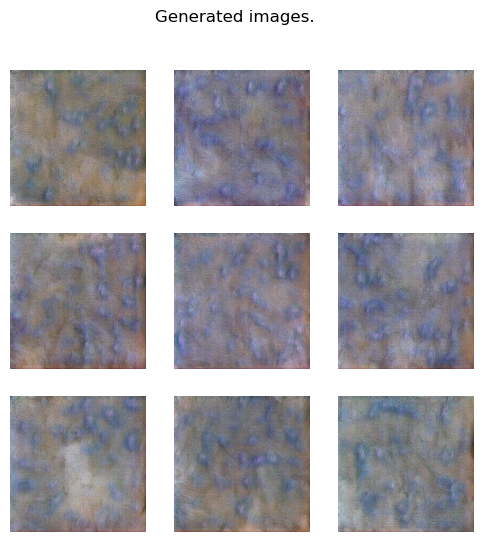

In [36]:
scaled_sample = plot_images(img_full, "Generated images.")

In [22]:
fid_list = []
for i in tqdm(range(10), "Calculating avg FID..."):
    for idx, test_batch in enumerate(train_dataloader):
        break

    fid = FrechetInceptionDistance(feature=64)
    fid.update((vae.latent_to_pil(test_batch[:9].to(device))*255).cpu().to(torch.uint8), real=True)
    fid.update((torch.from_numpy(scaled_sample).permute(0, 3, 2, 1)*255).to(torch.uint8), real=False)
    fid_list.append(fid.compute().item())

Calculating avg FID...: 100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


In [23]:
print(f"Averaged FID score for 10 random true image batches and generated sample is {np.average(fid_list)}.")

Averaged FID score for 10 random true image batches and generated sample is 35.880266952514646.
